In [86]:
# some standard python imports #
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import MAS_library as MASL
import smoothing_library as SL
import math


In [97]:
def inttopair(n, num_columns):
    row = n // num_columns
    col = n % num_columns
    return row, col

In [22]:
def densemap(df,grid,BoxSize, MAS, R, Filter, threads):
    pos = df.loc[:,['x','y','z']].to_numpy(dtype=np.float32)

    #Get density field.  MASL.MA is filling in the values of delta_g using CIC interpolation
    delta_g = np.zeros((grid,grid,grid), dtype=np.float32)
    MASL.MA(pos, delta_g, BoxSize, MAS, verbose=False)
    delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0
    
    
    
    # smooth the field
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    delta_g_smoothed = SL.field_smoothing(delta_g, W_k, threads)
    
    
    return delta_g_smoothed

In [56]:
def sigsorter(df, start, cur, col):
    para=df[col]
    para_mean=para.mean()
    para_std=para.std()

    low=para_mean+((cur-1)*para_std)
    high=para_mean+(cur*para_std)
    
    if cur == start:
        rows=df[df[col] < high].index
        newdf= df.loc[rows]
    if cur-1 == -1*cur:
        rows=df[df[col] >= low].index
        newdf= df.loc[rows]
    else:
        condition = (df[col] >= low) & (df[col] < high)
        rows=df[condition].index
        newdf= df.loc[rows]

    return newdf

In [71]:
def magsorter(df, low, high, col):
    para=df[col]
    condition = (df[col] >= low) & (df[col] < high)
    rows=df[condition].index
    newdf= df.loc[rows]
    
    return newdf

In [78]:
#Read in galaxy data
filename = 'galaxycat.csv'
galaxycat  = pd.read_csv(filename)

In [90]:
##Read in the snapshot data 

snapshot = 'snapshot_500'          #name of Gadget file
ptypes = [1]                       #this specifies that the simulation only contains dark matter particles
grid = 100                         #this is how you specify the size of your density grid (I just made it 100x100)
MAS      = 'CIC'                   #Cloud-in-Cell. This is just the interpolation scheme we are using to calculate the density
do_RSD   = False                   #don't do redshift-space distortions (https://en.wikipedia.org/wiki/Redshift-space_distortions)
axis     = 0                       #axis along which to place RSD; not used here
verbose  = False                   #whether to print information on the progress


# Compute the effective number of particles/mass in each voxel
delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)

# compute density contrast: delta = rho/<rho> - 1
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

BoxSize = 115  #from simulation params. Mpc/h 
R = 4       #smoothing kernal in Mpc/h
grid = delta.shape[0]
Filter  = 'Top-Hat' #type of smoothing kernal 
threads = 8   #computer threads, for parallelization 

# compute FFT (fast fourier transform) of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
delta_smoothed = SL.field_smoothing(delta, W_k, threads)


# building luminosity bins
k_mag=galaxycat['K_Mag']

k_mean=k_mag.mean()
k_std=k_mag.std()

k_min=math.floor(k_mag.min())
k_max=math.ceil(k_mag.max())


lum_list=[]

# bin via half mag
size=(k_max-k_min)*2

low=k_min
high=k_min+.5

label_list=[]
for i in range(size):
    templabel=str(low)+" - "+str(high)
    tempdf=magsorter(galaxycat, low, high, col)
    lum_list.append(tempdf)
    label_list.append(templabel)
    low+=.5
    high+=.5
    

# bin via sigma
# col='K_Mag'
# start_sig=-2
# size=np.abs(start_sig*2)+2

# for i in range(size):
#     cur_sig=start_sig+i
#     tempdf=sigsorter(galaxycat, start_sig, cur_sig, col)
#     lum_list.append(tempdf)

smoothed_list=[]
for i in lum_list:
    temp_smooth=densemap(i,grid,BoxSize, MAS, R, Filter, threads)
    smoothed_list.append(temp_smooth)



/var/folders/xm/20hbpbkx48gfnxf0j2y0gxd40000gn/T/ipykernel_11533/1762858434.py:7: RuntimeWarning: invalid value encountered in divide
  delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0


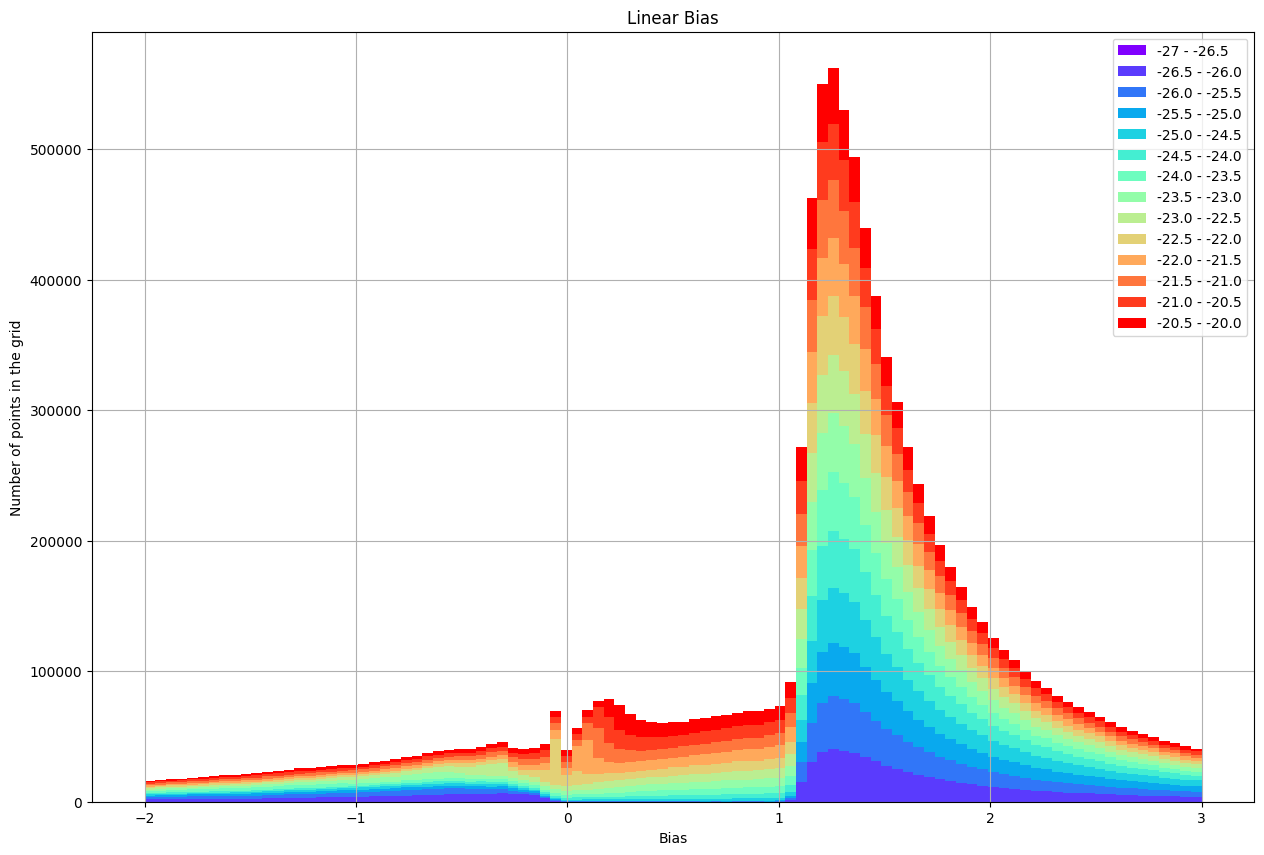

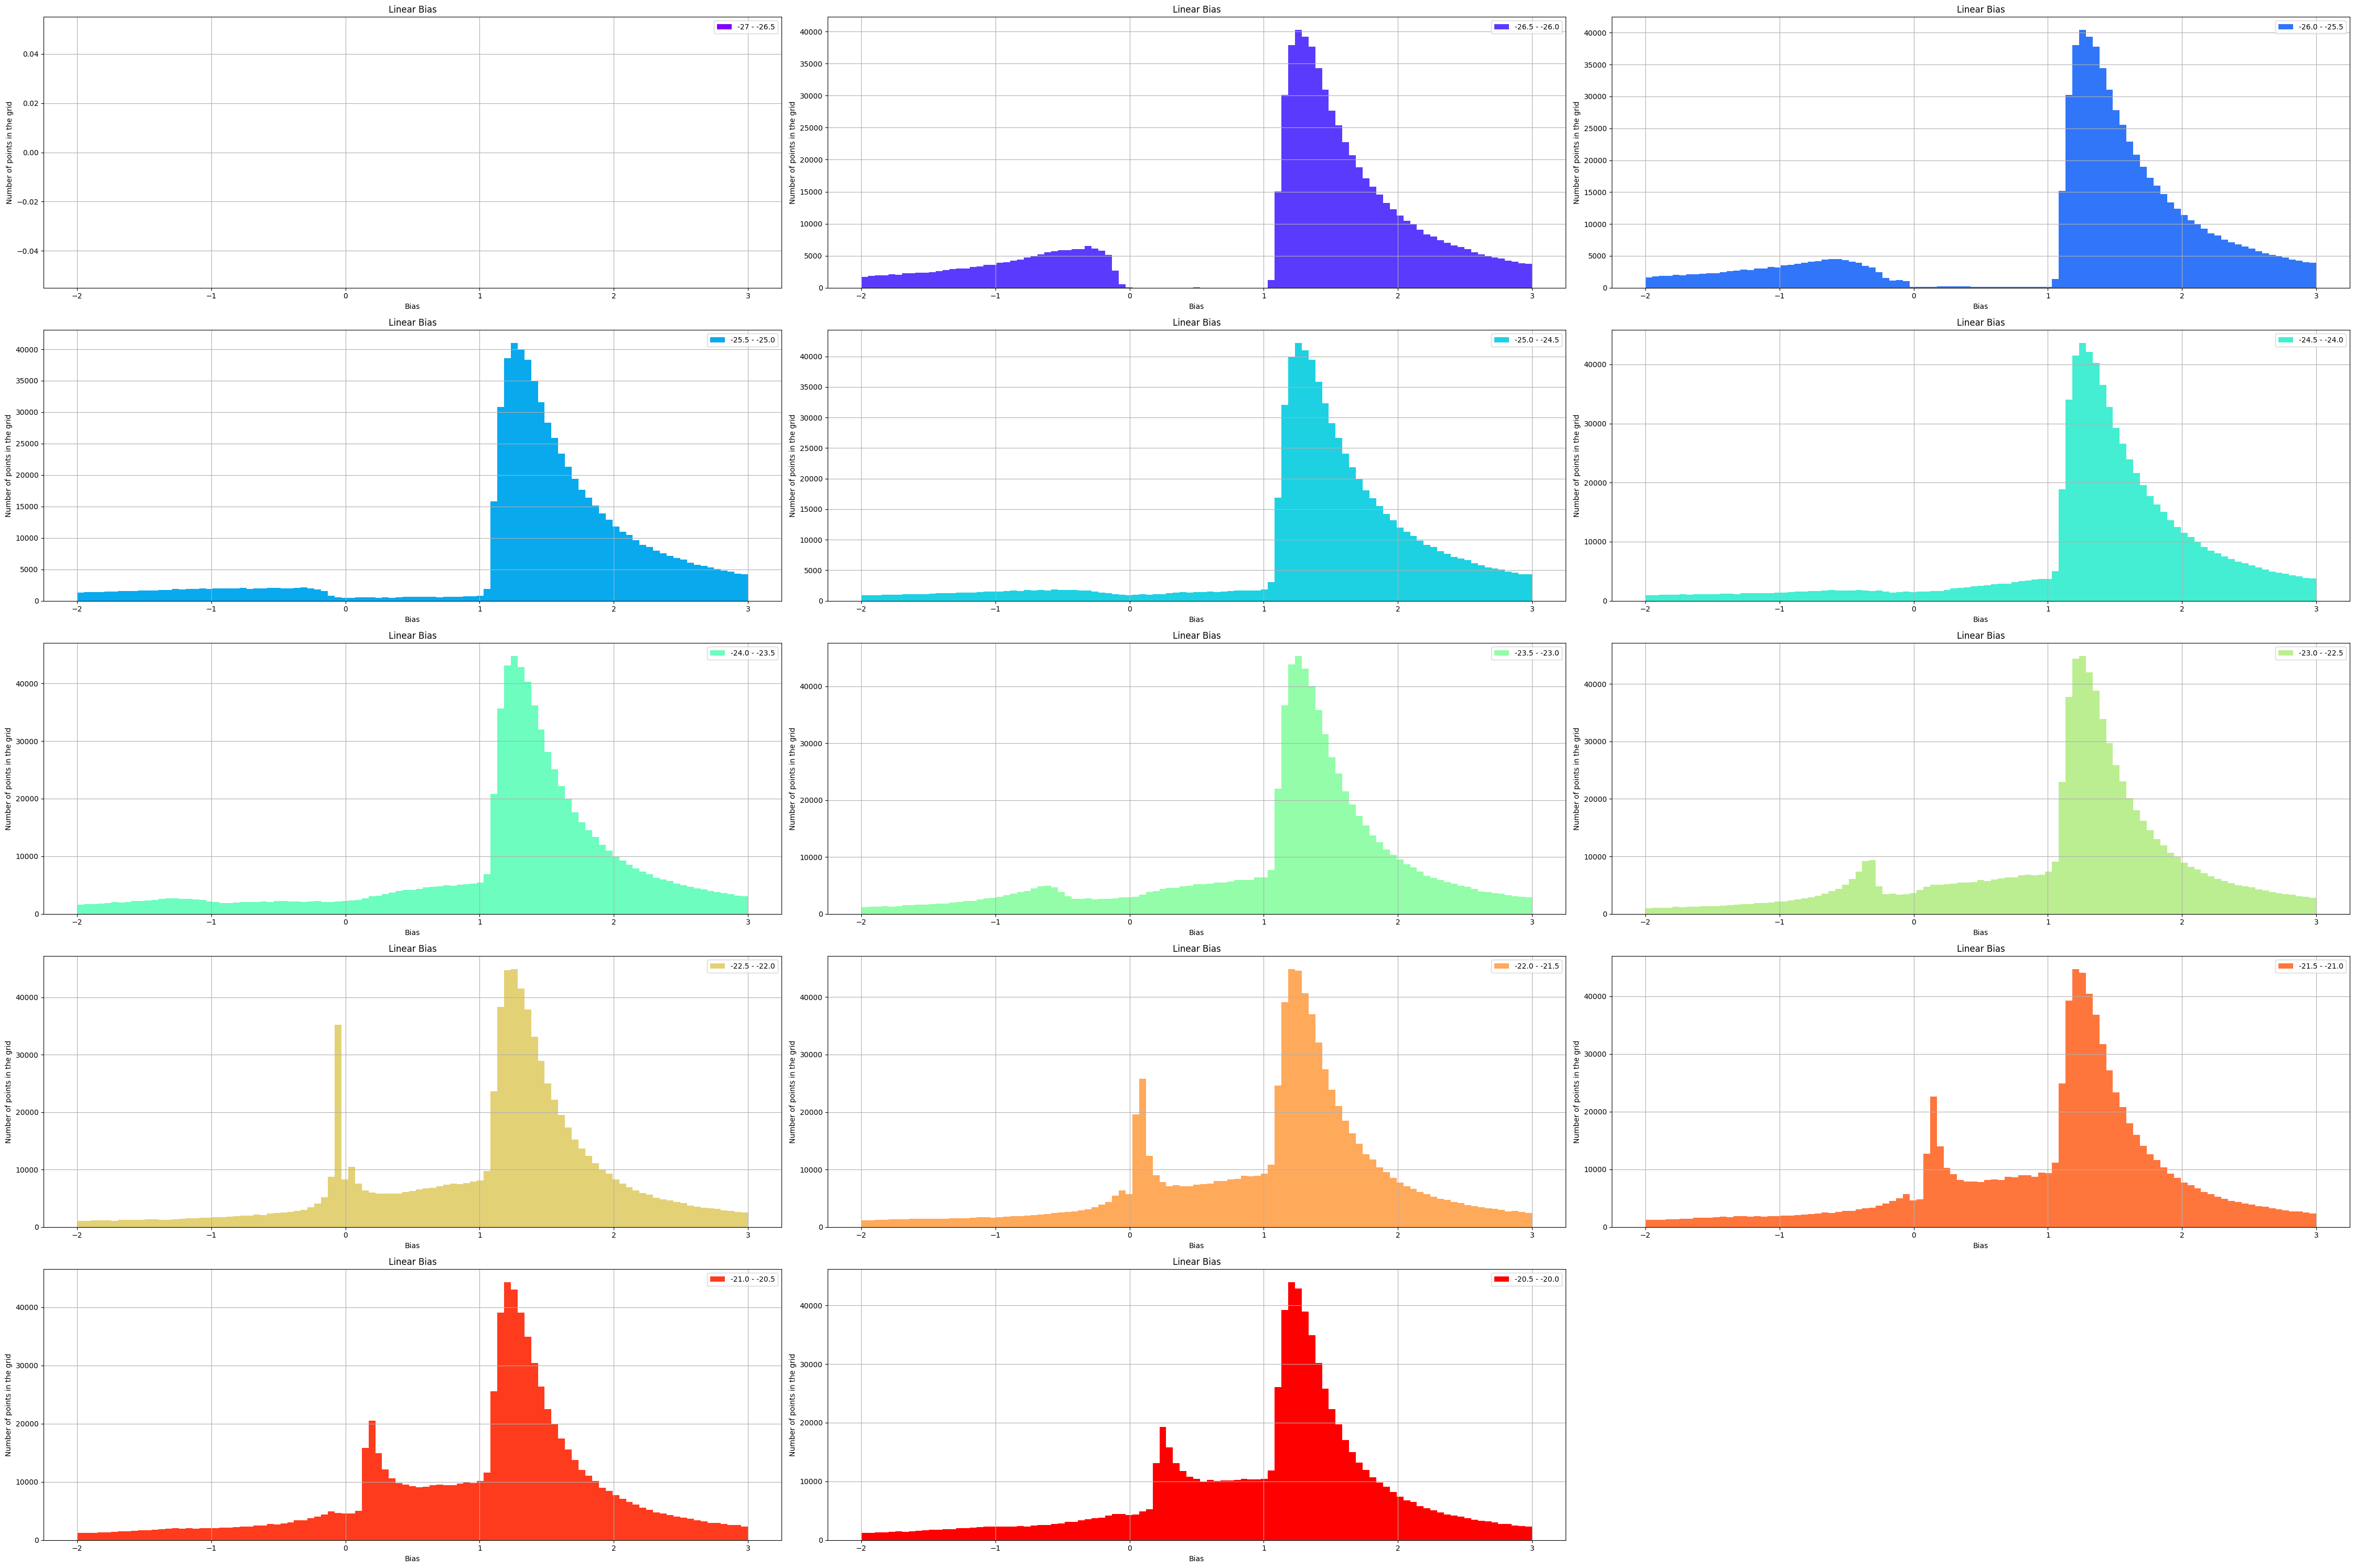

In [99]:
#label_list=[r"$<-2\sigma$",r"$-2\sigma{} - -1\sigma$",r"$-1\sigma{} - \mu$",r"$\mu{} - 1\sigma$",r"$1\sigma{} - 2\sigma$",r"$>2\sigma$"]

b_list=[]
color_list = cm.rainbow(np.linspace(0, 1, size))
for i in range(len(smoothed_list)):
    b=(smoothed_list[i]/delta_smoothed).flatten()
    label_list.append(lab)
    b_list.append(b)



plt.figure(figsize=(15,10))
hist = plt.hist(b_list, bins = np.linspace(-2,3,100),label=label_list,stacked=True,density=False,color=color_list)
plt.legend()
plt.title('Linear Bias')
plt.xlabel('Bias')
plt.ylabel('Number of points in the grid')
plt.grid()
plt.savefig("Bias_MagStack.png",format="png")
plt.show()

height=math.ceil(size/3)
fig =plt.figure(figsize=(45,30))
for i in range(len(b_list)):
    q,r=inttopair(i,3)
    ax = plt.subplot2grid((height, 3), (q, r), rowspan=1, colspan=1)
    
    hist = ax.hist(b_list[i], bins = np.linspace(-2,3,100),label=label_list[i],color=color_list[i])
    ax.legend()
    ax.title.set_text('Linear Bias')
    ax.set_xlabel('Bias')
    ax.set_ylabel('Number of points in the grid')
    ax.grid()

plt.savefig("Bias_Magind.png",format="png")
plt.tight_layout()
plt.show()

In [66]:
for i in lum_list:
    tempk_mag=i['K_Mag']

    tempk_mean=tempk_mag.mean()
    print(len(i))
    print(tempk_mean)

1337
-25.133962860292204
7264
-23.944330826033866
12972
-22.666424154766997
16111
-21.35133669358546
9059
-20.344231666950936
0
nan


In [67]:
k_min=k_mag.min()
k_max=k_mag.max()

print(k_min)
print(k_max)

-26.47856102425495
-20.000114742212897


In [101]:
print(len(galaxycat))

46755
